機械学習における不均衡データの問題点と対処法について
https://blog.amedama.jp/entry/imbalanced-data

機械学習における分類問題では、扱うデータセットに含まれるラベルに偏りのあるケースがある。 これは、例えば異常検知の分野では特に顕著で、異常なデータというのは正常なデータに比べると極端に数が少ない。 正常なデータが 99.99% なのに対し異常なデータは 0.01% なんてこともある。 このようなデータセットは不均衡データ (Imbalanced data) といって機械学習で扱う上で注意を要する。

今回は、不均衡データを扱う上での問題点と、その対処法について見てみる。 なお、登場する分類問題の評価指標については、以前このブログで扱ったことがあるのでそちらを参照のこと。

In [2]:
from sklearn.datasets import make_classification
args = {
'n_samples': 5000,
'n_features': 2,
'n_informative': 2,
'n_redundant': 0,
'n_repeated': 0,
'n_classes': 2,
'n_clusters_per_class': 1,
'weights': [0.99, 0.01],
'random_state': 42,
}
X, y = make_classification(**args)

用意したデータには約 99% の Negative なデータと約 1% の Positive なデータが含まれる。

>>> len(y[y == 0])
4922
>>> len(y[y == 1])
78

先ほど生成したデータは二次元の特徴量を持っているので二次元の散布図として可視化してみよう。

すると、次のようなグラフが得られる。 オレンジ色が Positive なデータで青色が Negative なデータになっている。 完全な分離は難しそうな感じ。

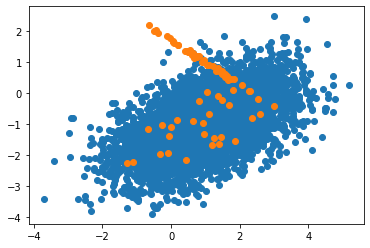

In [6]:
from matplotlib import pyplot as plt
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])
plt.show()

ロジスティック回帰でモデルを作ってみる
まずは不均衡データをそのまま使ってロジスティック回帰でモデルを作ってみよう。 どんなことが起こるだろうか。

まずはモデルを用意する。

まずはモデルを用意する。

In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs')

#http://kotarotanahashi.github.io/blog/2015/10/03/l-bfgsfalseshi-zu-mi/

#文字列を指定．最適解の探索手法を newton-cg，lbfgs，liblinear，sag から選択する．
#小さなデータセットの場合は「liblinear」が適切ですが、大きなデータセットの場合は「sag」と「saga」の方が高速です。
#マルチクラス問題の場合、「newton-cg」、「sag」、「saga」、および「lbfgs」のみが多項ロジットを処理します。
#「liblinear」は、1対RESTスキームに制限されています。

不均衡データをそのまま使って 5-Fold CV で学習・予測する。

In [31]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(clf, X, y, cv=5)

まずは、この結果を精度 (Accuracy) で評価してみよう。

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)
#0.9862

0.9864

そこで、試しに真陽性率 (Recall) を使って結果を評価してみよう。 これは、本当に Positive なデータに対してモデルがどれだけ正解できているかを示している。

In [13]:
from sklearn.metrics import recall_score
recall_score(y, y_pred)
#0.11538461538461539

0.1282051282051282

なんと約 11% しか正解できていなかった。 ようするに、ほとんどのデータを Negative と判断していることになる。

念のため適合率 (Precision) についても確認しておく。 これはモデルが Positive と判断したデータの中に、どれだけ本当に Positive なものがあったかを示している。

In [14]:
from sklearn.metrics import precision_score
precision_score(y, y_pred)
#1.0

1.0

こちらは 100% だった。 つまり、モデルはだいぶ慎重な判断をしていたといえる。 ようするに、なかなか Positive とは判断しないものの、判断したものについてはちゃんと正解していた。

最後に、混同行列 (Confusion Matrix) を確認しておこう。

In [32]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp
#(4922, 0, 69, 9)

(4922, 0, 68, 10)

confusion matrixを美しく表示する
https://evaluelog.com/post-122/

Text(83.40000000000006, 0.5, 'Real')

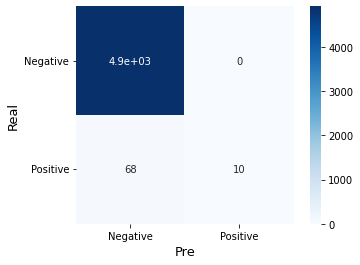

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
cm = pd.DataFrame(data=conf_matrix, index=["Negative", "Positive"], 
                           columns=["Negative", "Positive"])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Pre", fontsize=13, rotation=0)
plt.ylabel("Real", fontsize=13)

データに重みをつける
False Negative を減らすための施策としてはデータの重み付けが考えられる。 これは、特定のラベルをより重要視するということ。

例えば scikit-learn のロジスティック回帰であれば class_weight というオプションでラベルの重みが変更できる。 今回は例として含まれるラベルの割合の逆数を重みにした。

In [34]:
weights = {
 0: 1 / (len(y[y == 0]) / len(y)),
 1: 1 / (len(y[y == 1]) / len(y)),
}
clf = LogisticRegression(solver='lbfgs', class_weight=weights)
y_pred = cross_val_predict(clf, X, y, cv=5)

In [35]:
print(accuracy_score(y, y_pred)
,precision_score(y, y_pred)
,recall_score(y, y_pred))

0.7804 0.047872340425531915 0.6923076923076923


In [36]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp

(3848, 1074, 24, 54)

Text(83.40000000000006, 0.5, 'Real')

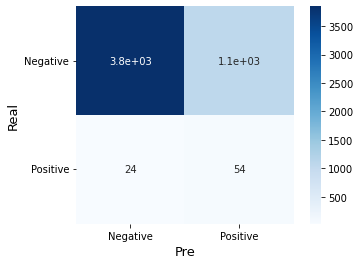

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
cm = pd.DataFrame(data=conf_matrix, index=["Negative", "Positive"], 
                           columns=["Negative", "Positive"])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Pre", fontsize=13, rotation=0)
plt.ylabel("Real", fontsize=13)

今回は Positive なデータをきちんと正解できた (True Positive) 割合が上がった。 代わりに、Negative なデータを誤って Positive と判断 (False Positive) してしまった割合も上がってしまった。 今回のモデルはだいぶ甘い判断で Positive と判定しており、いわばオオカミ少年といえる。

もちろん、先ほどのモデルと今回のモデルは、どちらかが全面的に優れているというわけではない。 不均衡データにおいては、問題によって適切な評価指標を使い、モデルの味付けをきちんと調整する必要があるということを示している。

サンプリングする


---


続いてはサンプリングを使った対処方法を試してみる。 ここでいうサンプリングというのは統計における標本抽出 (Sampling) と同じ。

不均衡データをサンプリングする方法としては次の二つがある。

アップサンプリング (Up Sampling) : 少ないデータを増やす
ダウンサンプリング (Down sampling) : 多いデータを減らす
ようするに、特定のラベルのデータを増やしたり減らしたりすることで、不均衡データを均衡データにできる。 今回は、よく使われるであろう後者のダウンサンプリングを試す。

ちなみに、不均衡データのもうひとつの問題点として計算量がある。 というのも、例えば異常検知において正常なデータが大量にあっても、実はあまり性能には寄与しない。 性能の向上に寄与しやすいのは、識別境界の近くにあるデータのため。 それ以外のデータは、モデルにがんばって学習させても、ほとんど計算コストの無駄になる恐れがある。 ダウンサンプリングは、多いラベルのデータを減らすので計算量の削減になる。

ダウンサンプリングの実装は imbalanced-learn を使うと楽ができる。

In [40]:
#今回は、無作為にサンプリングする RandomUnderSampler を使う。

from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

In [41]:
#これで Positive と Negative が同数になった均衡データが得られる。
len(X_resampled[y_resampled == 0, 0])
#78
len(X_resampled[y_resampled == 1, 0])
#78

78

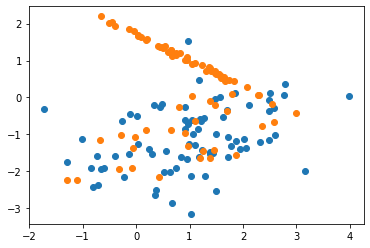

In [42]:
#サンプリングしたデータを試しに可視化してみよう。
plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1])
plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1])
plt.show()
#先ほどに比べると、ダウンサンプリングによって青い点が少なくなっていることが分かる

In [43]:
#試しにダウンサンプリングしたデータを使ってロジスティック回帰で分類させてみよう。
clf = LogisticRegression(solver='lbfgs')
y_sampled_pred = cross_val_predict(clf, X_resampled, y_resampled, cv=5)

In [45]:
accuracy_score(y_resampled, y_sampled_pred)
#0.7307692307692307
recall_score(y_resampled, y_sampled_pred)
#0.6923076923076923
precision_score(y_resampled, y_sampled_pred)
#0.75

0.7605633802816901